# **운동모션분류 AI**

---



## 목차


1. 프로젝트 내용
2. 필요 라이브러리 로드
3. 데이터 불러오기
4. EDA
5. Feature Engineering
6. Modeling
7. 결론
8. 추후 LOGLOSS를 줄이기 위한 대책 논의



---



---




# 1. 프로젝트 내용

3인칭 시점의 X,Y,Z 3축으로 순간의 가속도를 측정하는 가속도계(accelerometer)와 
순간의 위치를 측정하는 자이로스코프(gyroscope)를 활용해 측정된 센서 데이터는 주어진 운동 동작을 실행하여 얻어지는 데이터 값이다. 측정된 데이터와 수행한 운동 동작을 바탕으로 데이터 모델링을 통해 최적의 모델을 구한다.


---



# 2. 필요 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score,precision_score,recall_score, roc_curve, classification_report,precision_recall_curve
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler, Binarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold

# 오류무시
import warnings
warnings.filterwarnings(action="ignore")

In [2]:
# 구글드라이브 마운트 
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# 3. 데이터 불러오기

In [ ]:
path = "/content/gdrive/My Drive/colab/semi_hm/"

train = pd.read_csv(path+"train_features.csv")
train_labels=pd.read_csv(path+'train_labels.csv')
test=pd.read_csv(path+'test_features.csv')
submission=pd.read_csv(path+'sample_submission.csv')

In [ ]:
train.shape
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875000 entries, 0 to 1874999
Data columns (total 8 columns):
 #   Column  Dtype  
---  ------  -----  
 0   id      int64  
 1   time    int64  
 2   acc_x   float64
 3   acc_y   float64
 4   acc_z   float64
 5   gy_x    float64
 6   gy_y    float64
 7   gy_z    float64
dtypes: float64(6), int64(2)
memory usage: 114.4 MB


,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234


## 3.1 트레인데이터 추가 설명
- id : 같은 아이디는 하나의 운동모션 사이클을 의미
- time : 같은 아이디당 단위 시간 존재 1~600 time unit
- acc_x,y,z : 가속도계로 측정된 각각 좌표의 단위 시간당 가속도
- gy_x,y,z :자이로스코프로 측정된 각각 좌표의 위치

In [ ]:
train_labels

,id,label,label_desc
0,0,37,Shoulder Press (dumbbell)
1,1,26,Non-Exercise
2,2,3,Biceps Curl (band)
3,3,26,Non-Exercise
4,4,26,Non-Exercise
...,...,...,...
3120,3120,26,Non-Exercise
3121,3121,26,Non-Exercise
3122,3122,15,Dynamic Stretch (at your own pace)
3123,3123,26,Non-Exercise


## 3.2 레이블데이터 추가 설명
 - 각각의 아이디 마다 지정된 운동모션이 존재함 

 <예> 아이디 0의 경우 어깨운동(shoulder press)이며 이는 37번 레이블에 해당

# 4. EDA

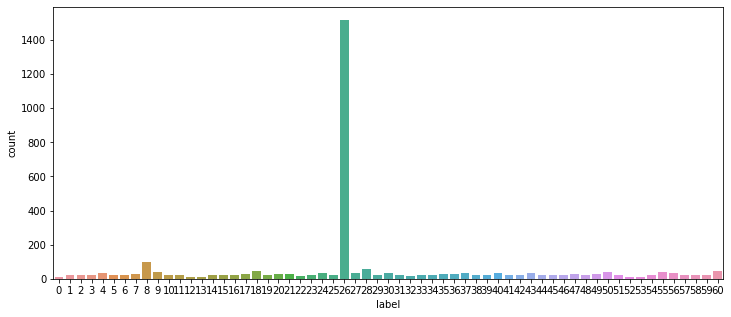

In [ ]:
# target data 분포 확인.
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
y  = train_labels['label']
ax = sns.countplot(y,label="Count")  

## 4.1 레이블 데이터의 분포확인
26번 레이블의 경우 운동을 하지않는 상태이며, 운동을 하지않는 상태가 다른 운동모션에 비해 압도적으로 많다.

In [ ]:
# id 별로 acc, gy 변화 확인
def plot_acc_id(df, id_num):
    return df.query('id == @id_num')[['time', 'acc_x', 'acc_y', 'acc_z']].plot(x = 'time')

def plot_gy_id(df, id_num):
    return df.query('id == @id_num')[['time', 'gy_x', 'gy_y', 'gy_z']].plot(x = 'time')

## 4.2 아이디 별 가속도/위치 데이터 확인

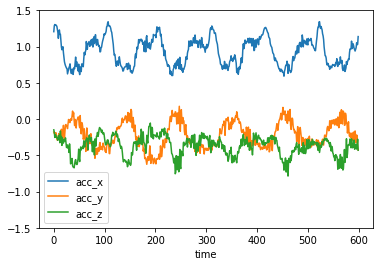

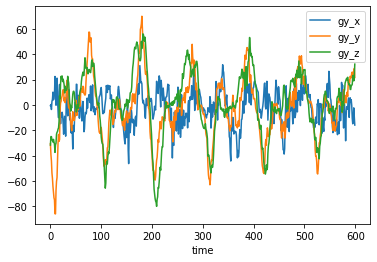

In [ ]:
# Shoulder Press (dumbbell)
plot_acc_id(train, 0)
plt.ylim((-1.5, 1.5))
plot_gy_id(train, 0)

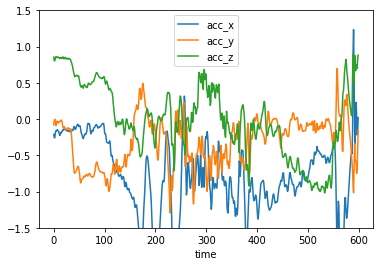

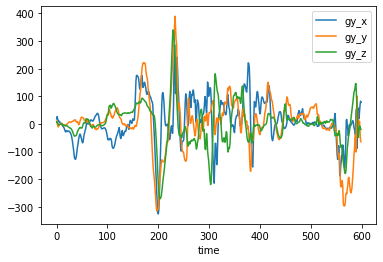

In [ ]:
# Non-Exercise
plot_acc_id(train, 1)
plt.ylim((-1.5, 1.5))
plot_gy_id(train, 1)

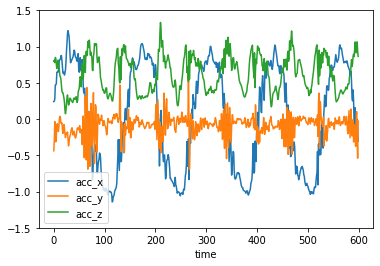

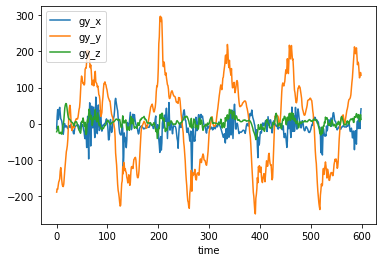

In [ ]:
# Biceps Curl (band)
plot_acc_id(train, 2)
plt.ylim((-1.5, 1.5))
plot_gy_id(train, 2)

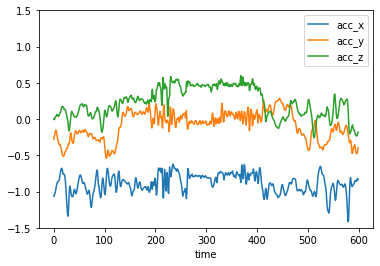

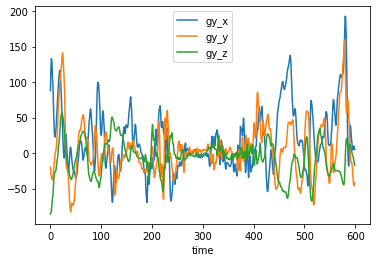

In [ ]:
# Non-Exercise
plot_acc_id(train, 3)
plt.ylim((-1.5, 1.5))
plot_gy_id(train, 3)

## 4.3 데이터 시각화에 따른 분석결과: 
 레이블 0번 (어깨운동)의 경우 가속도 그래프에서 x축의 값이 다른 두 축의 값에 비해 높다. 이는, 어깨운동을 분류하는 기준이 될 가능성이 존재한다.

레이블 2번 (이두근운동)의 경우, 가속도 그래프의 x축의 변동폭이 다른 두 축의 값에 비해 크며, 위치값에서는 y축의 변동이 다른 두축의 변동보다 크다. 이 역시 이두근 운동을 분류하는 기준이 될 수 있다. 

레이블 1,3 번의 경우 같은 운동모션(Non-exercise), 즉 운동을 하지 않는 상태임으로, 비슷한 패턴을 가지는 것이 예상되었으나, 그래프상에서 그 패턴이 비슷하다고 보기 힘들다. 


# 5. Feature Engineering

하나의 아이디 별로 1-600 단위시간이 존재함으로 이를 통합하여 하나의 아이디에 대표되는 값을 선정하였다. 통합과정에서 각각의 아이디는 '최대값','최소값','평균값','분산값' 그리고 '중위값'을 갖는다.

In [ ]:
features = ['id', 'acc_x', 'acc_y', 'acc_z', 'gy_x', 'gy_y', 'gy_z']                
X_train = train[features].groupby('id').agg(['max', 'min', 'mean','var','median'])
X_test = test[features].groupby('id').agg(['max', 'min', 'mean','var','median'])

In [ ]:
# 통합을 통해 데이터의 크기가 줄어든것을 볼수있다. 
X_train.shape, X_test.shape

((3125, 30), (782, 30))

In [ ]:
X_train.head()

acc_x                      ...      gy_z                       
         max       min      mean  ...      mean          var    median
id                                ...                                 
0   1.344268  0.591940  0.931329  ...  1.182107   638.834979  1.913286
1   1.234020 -2.156208 -0.766580  ...  1.393294  5707.098884 -0.655819
2   1.219836 -1.142847  0.039836  ...  3.053291   193.775778  3.568888
3  -0.622250 -1.417751 -0.887702  ... -5.869898   559.187841 -3.853078
4   0.599720 -2.429109 -0.659018  ...  4.453382  2129.668017 -0.750283

[5 rows x 30 columns]

In [ ]:
y_train = train_labels['label']
y_train

0       37
1       26
2        3
3       26
4       26
        ..
3120    26
3121    26
3122    15
3123    26
3124     2
Name: label, Length: 3125, dtype: int64

# 6. Modeling

In [ ]:
# X_train : 전체 트레인 데이터 X_test: 전체 테스트 데이터 y_train: 답안 데이터
my_score = {'acc':'accuracy','loss':'neg_log_loss'}
my_hyper_param = {  "n_estimators"      :[300] ,
                    "max_depth"        :[5,7,9],
                    "min_samples_leaf" :[1,3],
                  "random_state" : [121]
                 }
rf_model = RandomForestClassifier()
gcv_model = GridSearchCV(rf_model, param_grid=my_hyper_param, scoring=my_score, refit="loss", cv=5, verbose=0)
# # 튜닝된 rf_model 완성.

# # 이 모델을 이용해 학습 시킨다. fit 함수에 fit, predict, score 내장 loop 등이 포함되어있다.
gcv_model.fit(X_train,y_train)

print("best_estimator_", gcv_model.best_estimator_)
print("best_params_",    gcv_model.best_params_)
print("best_score_" ,    gcv_model.best_score_) # f1
gcv_df = pd.DataFrame(gcv_model.cv_results_)
print(gcv_df["mean_test_acc"].mean()) 
print(gcv_df["mean_test_f1"].mean()) 

In [ ]:
best_params_ {'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 300, 'random_state': 121}

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_jobs=-1, n_estimators=300 , max_depth=9, random_state=121 , min_samples_leaf=1)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
y_pred

array([[0.00019564, 0.00060547, 0.00454428, ..., 0.10733333, 0.        ,
        0.03498085],
       [0.00361471, 0.00038721, 0.00059069, ..., 0.00062164, 0.00040893,
        0.00251617],
       [0.01338503, 0.11265795, 0.00547411, ..., 0.00232969, 0.01096206,
        0.01542808],
       ...,
       [0.00395531, 0.0004442 , 0.00047872, ..., 0.00046205, 0.00043001,
        0.00292498],
       [0.00068966, 0.01249154, 0.00111762, ..., 0.        , 0.        ,
        0.00011798],
       [0.00387565, 0.0004442 , 0.00048543, ..., 0.00046353, 0.00042478,
        0.00291385]])

# 7. 결론

 본 프로젝트의 목적은 가속도계와 자이로스코프로 측정된 데이터를 통해 지정된 운동을 분류하는 것이다. 현재 위에서 구해진 결과 예측 값은 테스트 데이터셋에 들어 있는 센서데이터셋을 사용해, 앞서 구축한 모델에 의해 예측된 확률값이다. 하나의 아이디는 60개의 값을 가지며 각 값은 각각의 레이블일수있는 확률을 의미한다. 

 또한 이번 경진대회는 앞서 구해진 예측값의 LOGLOSS를 최소화하는 것으로 순위를 다툰다. 현재 프로젝트를 통해 최종적으로 구해진 LOGLOSS는 0.993 이며, 이는 프로젝트 참여 팀중 상위 30%에 해당한다. 

 

# 8. 추후 LOGLOSS를 줄이기위한 대책논의

본 프로젝트 기간 제한상 완료하지 못하였으나, LOGLOSS를 줄일수 있는 방법을 모색하였다. 

첫째, 앞서 데이터 분석 과정에서 보였듯이, Non-exercise 26번의 레이블의 분포가 다른 레이블에 비해 압도적으로 높았음으로 이에 대한 보완이 필요해 보인다. 앞선 프로젝트 모델링의 경우 데이터를 통합하여 사용하였음으로 이에대한 문제가 보완되었다고 생각했으나, 데이터의 수의 밸런스를 맞추는 경우를 생각해 볼수있다.

둘째, 이번 프로젝트에서 사용한 모델은 랜덤포레스트이며 그리드서치를 통해 파인튜닝을 거친 모델이다. 이외에도 XGBoost 등 다른 머신러닝모델을 시도해봄으로써 LOGLOSS를 줄이는 결과를 가져올수있다. 

셋째, 데이터의 양이 적지 않음으로 딥러닝 모델을 시도해볼수있다. 